# Clasificador de imágenes usando Flax

* El objetivo es implementar una CNN para clasificar imágenes.

## 1. Creación del dataset

* Referencia: https://www.tensorflow.org/datasets/api_docs/python/tfds/folder_dataset/ImageFolder

In [44]:
# cargamos las librerías
import tensorflow_datasets as tfds
import tensorflow as tf

In [45]:
# Training hyperparameters
batch_size = 16
train_steps = 128
eval_every = 10

In [46]:
builder = tfds.ImageFolder("../data/fruit-vegetables")
print(builder.info)

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_dir='/Users/alejandro/tensorflow_datasets/image_folder/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=13),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=129, num_shards=1>,
        'train': <SplitInfo num_examples=1117, num_shards=1>,
    },
    citation="""""",
)


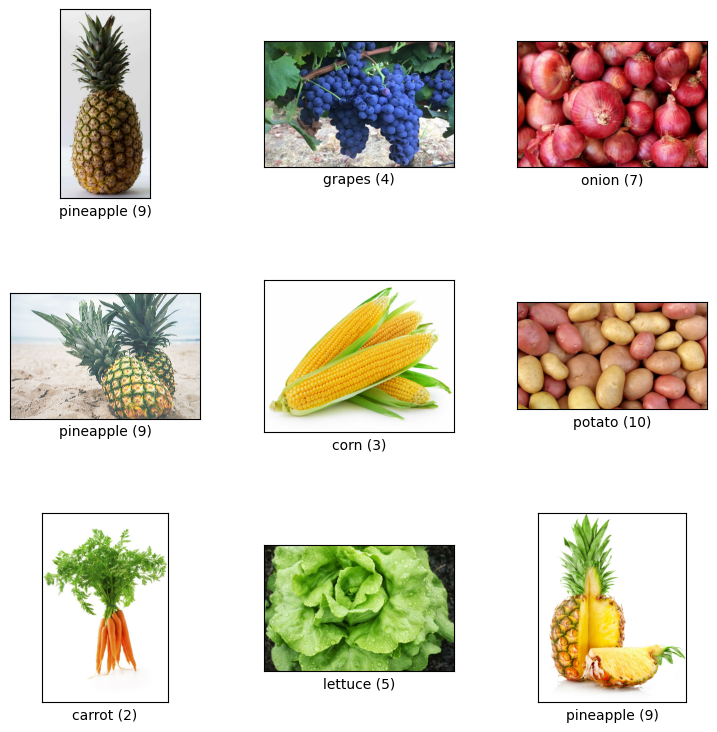

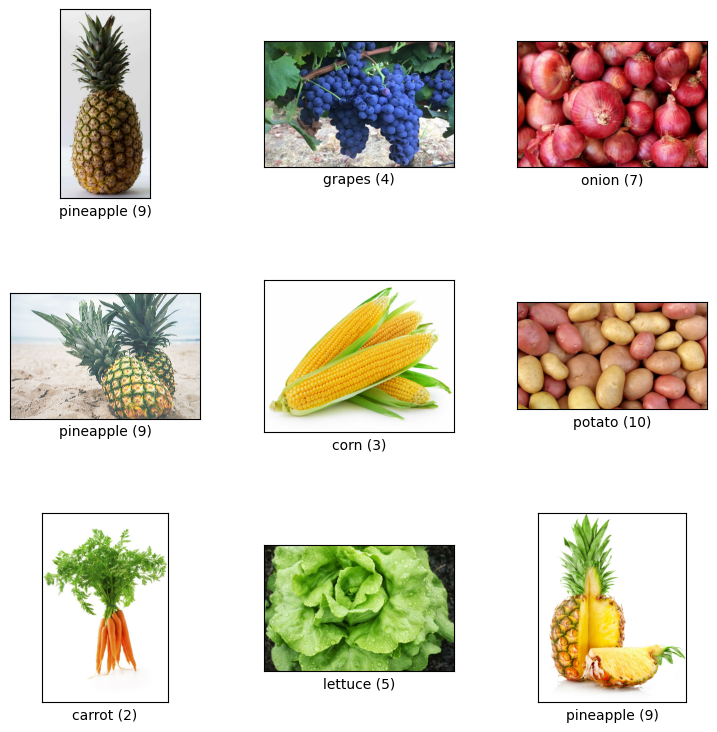

In [47]:
# Solo cargamos los datos de entrenamiento
train_ds, test_ds = builder.as_dataset(split=['train','test'], shuffle_files=True)
tfds.show_examples(train_ds, builder.info)

## 2. Preparación de los datos


In [48]:
# Normalizamos las imágenes a un rango de 0 a 1.
image_size = (244,244)
train_ds = train_ds.map(
    lambda sample: {
        'image': tf.image.resize_with_crop_or_pad(tf.cast(sample['image'], tf.float32)/255, image_size[0], image_size[1]), 'label':sample['label']
    }
)
test_ds = test_ds.map(
    lambda sample: {
        'image': tf.image.resize_with_crop_or_pad(tf.cast(sample['image'], tf.float32)/255, image_size[0], image_size[1]), 'label':sample['label']
    }
)
#train_ds = train_ds.repeat().shuffle(1024)


# Generamos batches y luego toma (crear) un dataset con a lo mucho train_steps imagenes. Precarga 1 imagen a la vez.
train_ds = train_ds.repeat().shuffle(1024)
train_ds = train_ds.batch(batch_size, drop_remainder=True).take(train_steps).prefetch(1)
test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

## 3. Definición del modelo

In [49]:
from flax import nnx
from functools import partial

In [50]:
class AlexNet(nnx.Module):
  """Implementación del modelo de AlexNet adapatado."""

  def __init__(self, *, rngs: nnx.Rngs):
    """Creamos las operaciones."""
    self.conv1 = nnx.Conv(3, 96, kernel_size=(11, 11), strides=4, padding='VALID', rngs=rngs)
    self.conv2 = nnx.Conv(96, 256, kernel_size=(5, 5), strides=1, padding='SAME', rngs=rngs)
    self.conv3 = nnx.Conv(256, 384, kernel_size=(3, 3), strides=1, padding='SAME', rngs=rngs)
    self.conv4 = nnx.Conv(384, 384, kernel_size=(3, 3), strides=1, padding='SAME', rngs=rngs)
    self.conv5 = nnx.Conv(384, 256, kernel_size=(3, 3), strides=1, padding='SAME', rngs=rngs)
    self.max_pool1 = partial(nnx.max_pool, window_shape=(3, 3), strides=(2, 2), padding='VALID') # Partial es para dejar pendientes algunos argumentos.
    self.max_pool2 = partial(nnx.max_pool, window_shape=(3, 3), strides=(2, 2), padding='SAME')
    self.linear1 = nnx.Linear(in_features=16384,out_features=4096, rngs=rngs)
    self.linear2 = nnx.Linear(in_features=4096, out_features=4096, rngs=rngs)
    self.linear3 = nnx.Linear(4096, 13, rngs=rngs)

  def __call__(self, x):

    # Primer bloque convolucional
    x = self.max_pool1(nnx.relu(self.conv1(x))) 
    
    # Segundo bloque convolucional
    x = self.max_pool2(nnx.relu(self.conv2(x))) 
    
    # Tercer bloque convolucional
    x = nnx.relu(self.conv3(x)) 
    x = nnx.relu(self.conv4(x)) 
    x = self.max_pool2(nnx.relu(self.conv5(x))) 

    # Flatten
    x = x.reshape(x.shape[0], -1)
    print("flatten shape: ", x.shape)

    # Linear
    x = nnx.relu(self.linear1(x))
    x = nnx.relu(self.linear2(x))
    x = self.linear3(x)
    return x

In [51]:
# Instanciamos el modelo
model = AlexNet(rngs=nnx.Rngs(0))

# Y lo visualizamos
nnx.display(model)

In [52]:
# Test the model
import jax.numpy as jnp
x = jnp.ones((1,image_size[0], image_size[1], 3))
y = model(x)
y

flatten shape:  (1, 16384)


Array([[-0.03840534,  0.06003635, -0.23055547, -0.15515439, -0.08901926,
        -0.1342119 ,  0.06301367, -0.05201097,  0.01910744, -0.00369206,
         0.11560395,  0.13920048,  0.02678613]], dtype=float32)

## 4. Definición del optimizador

In [53]:
import optax

learning_rate = 0.005
momentum = 0.9

# recibe un modelo y un optimizador de Optax.
optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))

# Creamos una multimétrica para revisar dos a la vex
metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)

nnx.display(optimizer)

## 5. Crear rutina de entrenamiento

In [54]:
# Funciones para aplicar pérdida y paso de entrenamiento
def loss_fn(model: AlexNet, batch):
  logits = model(batch['image'])
  loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=batch['label']
  ).mean()
  return loss, logits

@nnx.jit
def train_step(model: AlexNet, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
  """Train for a single step."""
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=True) # Se crea una función que evalua la función argumento y su gradiente. En este caso, la pérdida y su gradiente.
  (loss, logits), grads = grad_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.
  optimizer.update(grads)  # In-place updates.

@nnx.jit
def eval_step(model: AlexNet, metrics: nnx.MultiMetric, batch):
  loss, logits = loss_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.

## 6. Entrenar y evaluar modelo

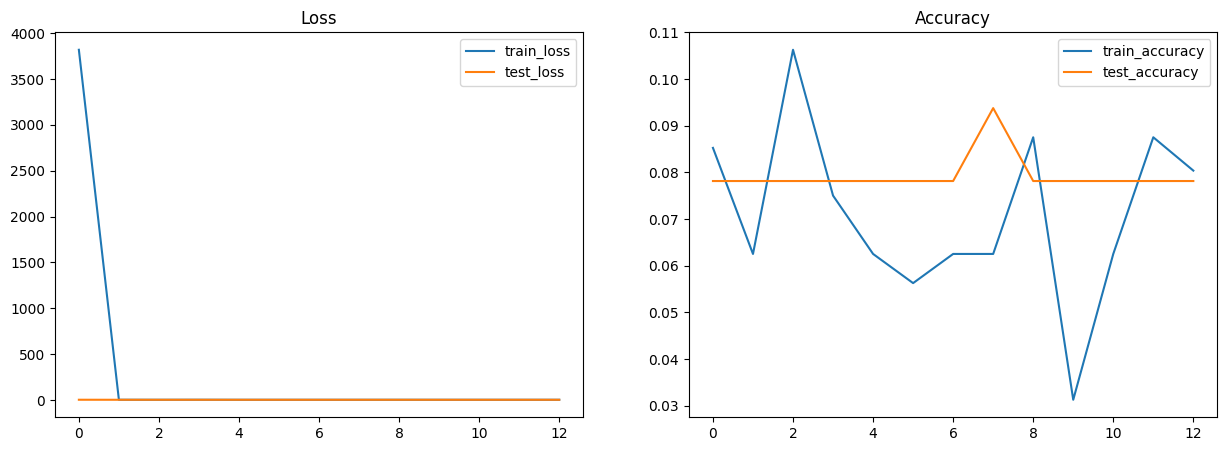

In [55]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

metrics_history = {
  'train_loss': [],
  'train_accuracy': [],
  'test_loss': [],
  'test_accuracy': [],
}

for step, batch in enumerate(train_ds.as_numpy_iterator()):
  # Run the optimization for one step and make a stateful update to the following:
  # - The train state's model parameters
  # - The optimizer state
  # - The training loss and accuracy batch metrics
  train_step(model, optimizer, metrics, batch)

  if step > 0 and (step % eval_every == 0 or step == train_steps - 1):  # One training epoch has passed.
    # Log the training metrics.
    for metric, value in metrics.compute().items():  # Compute the metrics.
      metrics_history[f'train_{metric}'].append(value)  # Record the metrics.
    metrics.reset()  # Reset the metrics for the test set.

    # Compute the metrics on the test set after each training epoch.
    for test_batch in test_ds.as_numpy_iterator():
      eval_step(model, metrics, test_batch)

    # Log the test metrics.
    for metric, value in metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    metrics.reset()  # Reset the metrics for the next training epoch.

    clear_output(wait=True)
    # Plot loss and accuracy in subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title('Loss')
    ax2.set_title('Accuracy')
    for dataset in ('train', 'test'):
      ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
      ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
    ax1.legend()
    ax2.legend()
    plt.show()

## 7. Inferencias


In [56]:
model.eval() # Switch to evaluation mode.

@nnx.jit
def pred_step(model: AlexNet, batch):
  logits = model(batch['image'])
  return logits.argmax(axis=1)

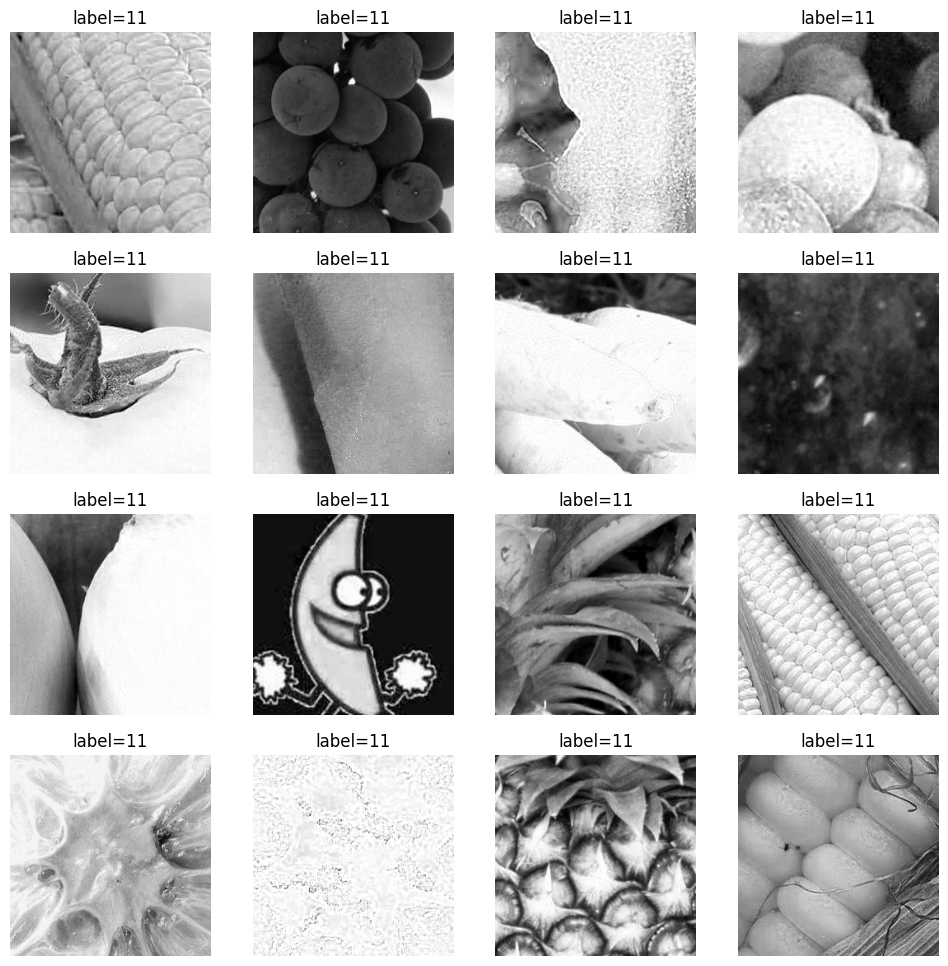

In [62]:
test_batch = test_ds.as_numpy_iterator().next()
pred = pred_step(model, test_batch)

fig, axs = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
  ax.set_title(f'label={pred[i]}')
  ax.axis('off')